<a href="https://colab.research.google.com/github/davideandres95/ml_comm/blob/main/tut03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Tutorial 3: 
November 4, 2021



In [3]:
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt

### Problem 3.1 - Numeric stability
Consider the code :

In [2]:
def f64(x):
    x = x.type(torch.float64)
    x = torch.exp(x)
    return torch.log(x)

def f16(x):
    x = x.type(torch.float16)
    return x

1. What is the smallest integer value x for which f64(x)!=x?

In [3]:
for L_expected in torch.arange(0, 1000):
    L_actual = f64(L_expected)
    if L_expected != L_actual:
        break
print(f'expected: {L_expected}, f64({L_expected})={f64(L_expected)}')

expected: 710, f64(710)=inf


2. For the value x determined in 1., do you have f16(x)=x?

In [4]:
print(f'f16({L_expected})={f16(L_expected)}')

f16(710)=710.0


3. Repeat the analysis for 1. and 2. to compare a float64 implementation of the log-
sum-exp expression on the left-hand side of (3.15) to a float16 implementation
of the right-hand side of .

$$ \log_2 \big( \sum_{j=0}^{M-1}  e^{\ell_j}\big) = \ell^*  \log_2(e) + \log_2 \big(\sum_{j=0}^{M-1} e^{\ell_j-\ell*}\big)$$

 $$  \ell^* = \max \{ \ell_0,\dots, \ell_{M-1} \}$$

In [5]:
def left_hand_side_64(likelihoods):
    likelihoods = likelihoods.type(torch.float64)
    
    return(torch.log2(torch.sum(torch.exp(likelihoods))))

In [6]:
def rigth_hand_side_32(likelihoods):
    likelihoods = likelihoods.type(torch.float32)
    l_star = torch.max(likelihoods)
    diff = likelihoods - l_star
    return(l_star*torch.log2(torch.exp(torch.tensor(1.))) + torch.log2(torch.sum(torch.exp(diff))))

In [7]:
likelihoods = torch.tensor([1, 4, 13, 2])
print(f'Left hand side with float 64: {left_hand_side_64(likelihoods):.3f}')
print(f'Rigth hand side with float 32: {rigth_hand_side_32(likelihoods):.3f}')

Left hand side with float 64: 18.755
Rigth hand side with float 32: 18.755


### Problem 3.2 - How good is the simple AWGN NN Demapper?


In [4]:
def mapper(msg, alphabet=np.array([-3., -1., 1., 3.])):
    return alphabet[msg]

def awgn_channel(x, snr, seed=None):
    rng = np.random.Generator(np.random.PCG64(seed))
    power_x = np.mean(np.abs(X) ** 2)
    noise_power = power_x / snr
    noise = np.sqrt(noise_power) * rng.normal(size=x.shape) 
    return x + noise 

1. Calculate $P_{A|Y} (\cdot|y)$ in terms of channel output $y$, mapper function $\phi$, and noise
variance $\sigma^2_z$.

$$ P_{A|Y}(a|y) = \frac{P_A(a) P_{Y|A}(y|a)}{P_Y(y)} = \frac{P_A(a) P_{Y|A}(y|a)}{\sum_{j=0}^{M-1} P_{A}(j) P_{Y|A}(y|j)} $$ with $$P_{Y|A}(a|y) = \frac{1}{\sqrt{2 \pi \sigma_z ^2}} e ^{-\frac{1}{2 \sigma^2}(y-a)^2}$$

2. Suppose A is uniformly distributed. The signal-to-noise ratio (SNR) in dB is 
$$\text{SNRdB} = 10 \log\frac{E(X^2)}{E(Z^2)}.$$
For SNRdB = {5, 6, 7, ... , 10}, use sample sequences to calculate an equivocation estimate $\hat{H}(M|Y)$ and plot the mutual information estimate:
$$I(A; Y ) = H(A) - \hat{H}(A|Y ) $$ [bits]

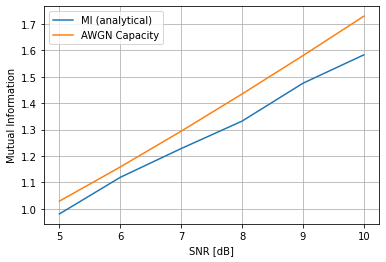

In [6]:
M = 4 # cardinality of the alphabet
chi = [-3., -1., 1., 3.] # alphabet
a = np.random.choice(M,10000) # messages
X = mapper(a) # symbols

def calculate_py_given_x(x, y, sigma2):
    return (1/(np.sqrt(2*np.pi*sigma2))) * np.exp(-(y-x)**2/sigma2/2) 


def calculate_px_given_y(x, y, sigma2, chi):
    py = 0
    for i in chi:
        py += 0.25 * calculate_py_given_x(i, y, sigma2)  
    pxy = 0.25 * calculate_py_given_x(x, y, sigma2) / py
    return pxy


SNRdBs = np.array([5,6,7,8,9,10])
mi = np.zeros(SNRdBs.size)
SNRs = 10**(SNRdBs/10)
for idx,snr in enumerate(SNRs):
    Y = awgn_channel(X, snr)
    pxy = calculate_px_given_y(X, Y, np.mean(np.abs(X) ** 2)/snr, chi)
    mi[idx] = np.log2(M)-(-np.mean(np.log2(pxy)))

plt.plot(SNRdBs, mi, label='MI (analytical)')
plt.plot(SNRdBs, 0.5 * np.log2(1+ SNRs), label='AWGN Capacity') 
plt.xlabel('SNR [dB]')
plt.ylabel('Mutual Information')
plt.legend()
plt.grid()

3. For each SNR value from 2., train an AWGN NN demapper as in Figure 3.6 using
the cross equivocation cost for log probabilities (3.18).



In [7]:
class awgn_demapper(nn.Module):
    def __init__(self):
        super().__init__()
        self.out = nn.Linear(1, 4)

    def forward(self, y):
        y = self.out(y)
        return y

In [8]:
# Prepare data
a_t = torch.Tensor(a.reshape(-1,))
a_t = a_t.type(torch.LongTensor)
# Loss function
loss_fn = nn.CrossEntropyLoss()

In [9]:
def calculate_prob(logit, a_t): 
    l = logit.detach().numpy()
    a = a_t.detach().numpy()
    la = l[range(len(a)), a]
    return np.exp(la) / np.sum(np.exp(l), 1)

# Trainings loop
probs = np.zeros((SNRs.size, 10000))
equivocations = np.zeros(SNRs.size)
for idx,snr in enumerate(SNRs):
    print(f'---- SNR is: {snr:.2f}')
    # Initialize network
    demap = awgn_demapper()
    # Optimizer
    optimizer = optim.Adam(demap.parameters(), lr=0.05)
    Y = awgn_channel(X, snr)
    y = torch.Tensor(Y.reshape(-1, 1))
    for j in range(1000):
        logit = demap(y).reshape(-1, 4)
        loss = loss_fn(logit, a_t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Printout and visualization
        if j % 50 == 0:
            print(f'epoch {j}: Loss = {loss.detach().numpy() :.4f}')
    probs[idx, :]=calculate_prob(logit, a_t)
    equivocations[idx] = loss / np.log(2) 
                                        

---- SNR is: 3.16
epoch 0: Loss = 1.9226
epoch 50: Loss = 0.7231
epoch 100: Loss = 0.7034
epoch 150: Loss = 0.7000
epoch 200: Loss = 0.6994
epoch 250: Loss = 0.6993
epoch 300: Loss = 0.6993
epoch 350: Loss = 0.6993
epoch 400: Loss = 0.6993
epoch 450: Loss = 0.6993
epoch 500: Loss = 0.6993
epoch 550: Loss = 0.6993
epoch 600: Loss = 0.6993
epoch 650: Loss = 0.6993
epoch 700: Loss = 0.6993
epoch 750: Loss = 0.6993
epoch 800: Loss = 0.6993
epoch 850: Loss = 0.6993
epoch 900: Loss = 0.6993
epoch 950: Loss = 0.6993
---- SNR is: 3.98
epoch 0: Loss = 2.2771
epoch 50: Loss = 0.6996
epoch 100: Loss = 0.6420
epoch 150: Loss = 0.6295
epoch 200: Loss = 0.6259
epoch 250: Loss = 0.6248
epoch 300: Loss = 0.6245
epoch 350: Loss = 0.6245
epoch 400: Loss = 0.6245
epoch 450: Loss = 0.6245
epoch 500: Loss = 0.6245
epoch 550: Loss = 0.6245
epoch 600: Loss = 0.6245
epoch 650: Loss = 0.6245
epoch 700: Loss = 0.6245
epoch 750: Loss = 0.6245
epoch 800: Loss = 0.6245
epoch 850: Loss = 0.6245
epoch 900: Loss = 0.

4. For the trained NN demappers, calculate equivocation estimates from input and output sequences. Plot the corresponding mutual information estimate. What is the gap in mutual information and in SNR, compared to the analytical demapper from 2.?

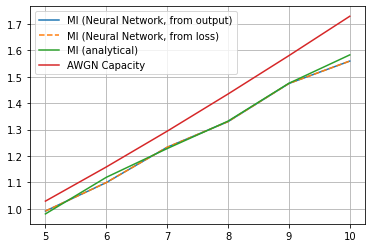

In [10]:
mi_nn = np.log2(4)-(-np.mean(np.log2(probs), axis=1))
mi_nn_from_loss = np.log2(4) - equivocations
plt.plot(SNRdBs, mi_nn, label='MI (Neural Network, from output)')
plt.plot(SNRdBs, mi_nn_from_loss, label='MI (Neural Network, from loss)', linestyle='dashed')
plt.plot(SNRdBs, mi, label='MI (analytical)')
plt.plot(SNRdBs, 0.5 * np.log2(1+ SNRs), label='AWGN Capacity')
plt.legend()
plt.grid()

6. For $\text{SNRdB} = 5$ and $-4 \leq  y  \leq 4$, plot the distributions $P_{A|Y} (i|y)$ as function of $y$ for $i = 0, 1, 2, 3$. For the same values of $y$, also plot the probabilities calculated from the log probabilities output by the NN demapper trained for $\text{SNRdB} = 5$. How well does the NN demapper approximate the analytical probabilities?

In [11]:
# Train the network at 5 dB
SNRdB = 5
snr =  10**(SNRdB/10)
Y = awgn_channel(X, snr)
# Initialize network
demap = awgn_demapper()
# Optimizer
optimizer = optim.Adam(demap.parameters(), lr=0.05)
a_t = torch.Tensor(a.reshape(-1,))
a_t = a_t.type(torch.LongTensor)
y = torch.Tensor(Y.reshape(-1, 1))
for j in range(1000):
    logit = demap(y).reshape(-1, 4)
    loss = loss_fn(logit, a_t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Printout and visualization
    if j % 50 == 0:
        print(f'epoch {j}: Loss = {loss.detach().numpy() :.4f}')

probs = calculate_prob(logit, a_t)

epoch 0: Loss = 2.7765
epoch 50: Loss = 0.7403
epoch 100: Loss = 0.7042
epoch 150: Loss = 0.6982
epoch 200: Loss = 0.6966
epoch 250: Loss = 0.6963
epoch 300: Loss = 0.6962
epoch 350: Loss = 0.6962
epoch 400: Loss = 0.6962
epoch 450: Loss = 0.6962
epoch 500: Loss = 0.6962
epoch 550: Loss = 0.6962
epoch 600: Loss = 0.6962
epoch 650: Loss = 0.6962
epoch 700: Loss = 0.6962
epoch 750: Loss = 0.6962
epoch 800: Loss = 0.6962
epoch 850: Loss = 0.6962
epoch 900: Loss = 0.6962
epoch 950: Loss = 0.6962


In [27]:
for name, param in demap.named_parameters():
    # print(type(param.data), param.size())
    print(name, param.data)

y = [1]
logit = demap(torch.Tensor(y).reshape(-1, 1)).reshape(-1, 4)
pay_nn = nn.functional.softmax(logit, 1).detach().numpy()
print('logits: ', logit)
print('probs: ', pay_nn)

out.weight tensor([[-1.4461],
        [-0.1614],
        [ 1.1742],
        [ 2.4590]])
out.bias tensor([-1.3747,  1.1932,  1.2169, -1.4086])
logits:  tensor([[-2.8208,  1.0318,  2.3911,  1.0504]], grad_fn=<ReshapeAliasBackward0>)
probs:  [[0.00357703 0.16853751 0.6561831  0.17170238]]


-5.000000000000018


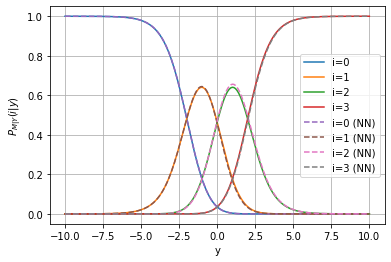

0.9792563


In [30]:
# Analytical:
sigma2 = np.mean(np.abs(X) ** 2)/snr
y = np.arange(-10, 10+0.1, 0.1)
print((y[50]))
for i in range(M):
    pay = calculate_px_given_y(chi[i], y, sigma2, chi)
    plt.plot(y, pay, label="i="+str(i))
    
# NN:
#logit = demap(torch.Tensor(y).reshape(-1, 1)).reshape(-1, 4).detach().numpy()
logit = demap(torch.Tensor(y).reshape(-1, 1)).reshape(-1, 4)
pay_nn = nn.functional.softmax(logit, 1).detach().numpy()
#pay_nn = np.exp(logit) / np.sum(np.exp(logit), 1).reshape(-1, 1)
for i in range(M):
    plt.plot(y, pay_nn[:, i].reshape(-1), label=f'i={i} (NN)', linestyle='dashed')

plt.grid()
plt.legend()
plt.xlabel('y')
plt.ylabel('$P_{M|Y} (i|y)$')
plt.show()
print(pay_nn[50,0])

### Problem 3.3 - Log probabilities versus probabilities

1. Repeat steps 3.-4. and 6. of Problem 3.2 for the demapper in Figure 3.6 terminated as
in Figure 3.3, using the cross equivocation cost (3.7). 
Do you observe differences to the results from Problem 3.2?


In [ ]:
class awgn_demapper2(nn.Module):
    def __init__(self):
        super().__init__()
        self.h1 = nn.Linear(1, 4)
        self.out = nn.Sigmoid()

    def forward(self, y):
        y = self.out(self.h1(y))
        return y/torch.sum(y, 1).reshape(-1, 1) 

In [ ]:
# Prepare data
y = torch.Tensor(Y.reshape(-1, 1))
a_t = torch.Tensor(a.reshape(-1,))
a_t = a_t.type(torch.LongTensor)

# Define loss function and optimizer
loss_fn = nn.NLLLoss()

equivocations = np.zeros(SNRs.size)
probs=np.zeros((SNRs.size,10000))
for idx,snr in enumerate(SNRs):
    print(f'--- SNR is: {snr:.2f}---')
    # Initialize network
    demap2 = awgn_demapper2()
    # Optimizer
    optimizer = optim.Adam(demap2.parameters(), lr=0.005)
    Y = awgn_channel(X, snr)
    y = torch.Tensor(Y.reshape(-1, 1))
    for j in range(10000):
        prob = demap2(y).reshape(-1, 4)
        loss = loss_fn(torch.log(prob), a_t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Printout and visualization
        if j % 50 == 0:
            print(f'epoch {j}: Loss = {loss.detach().numpy() :.4f}')
    probs[idx,:] = prob.detach().numpy()[range(len(a)), a]
    equivocations[idx] = loss / np.log(2) 

In [ ]:
mi_nn_2 = np.log2(4)-(-np.mean(np.log2(probs), axis=1))
mi_nn_2_loss = np.log2(4)-equivocations
plt.plot(SNRdBs, mi_nn_2, label='MI (Neural Network 2)')
plt.plot(SNRdBs, mi_nn_2_loss, linestyle='dashed', label='MI (Neural Network 2)')
plt.plot(SNRdBs, mi, label='MI (analytical)')
plt.plot(SNRdBs, 0.5 * np.log2(1+ SNRs), label='AWGN Capacity')
plt.legend()
plt.grid()
plt.show()
# TODO: problems for large SNR ==> this should be due to numerical issues

2. Repeat steps 3.-5. of Problem 3.2 for the demapper in Figure 3.6 terminated as in Figure 3.4, using the cross equivocation cost (3.7). 
Do you observe differences to the results from Problem 3.2?



In [ ]:
class awgn_demapper3(nn.Module):
    def __init__(self):
        super().__init__()
        self.h1 = nn.Linear(1, 4)
        self.out = nn.Softmax(dim=1)

    def forward(self, y):
        y = self.out(self.h1(y))
        return y

In [ ]:
# Prepare data
y = torch.Tensor(Y.reshape(-1, 1))
a_t = torch.Tensor(a.reshape(-1,))
a_t = a_t.type(torch.LongTensor)

# Define loss function and optimizer
loss_fn = nn.NLLLoss()


In [ ]:
# Trainings loop
probs=np.zeros((SNRs.size,10000))
for idx,snr in enumerate(SNRs):
    print(f'--- SNR is: {snr:.2f}---')
    # Initialize network
    demap3 = awgn_demapper3()
    # Optimizer
    optimizer = optim.Adam(demap3.parameters(), lr=0.05)
    Y = awgn_channel(X, snr)
    y = torch.Tensor(Y.reshape(-1, 1))
    for j in range(1000):
        prob = demap3(y).reshape(-1, 4)
        loss = loss_fn(torch.log(prob), a_t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Printout and visualization
        if j % 50 == 0:
            print(f'epoch {j}: Loss = {loss.detach().numpy() :.4f}')
    probs[idx,:] = prob.detach().numpy()[range(len(a)), a]

In [ ]:
mi_nn_3 = np.log2(4)-(-np.mean(np.log2(probs), axis=1))
plt.plot(SNRdBs, mi_nn_3, label='MI (Neural Network 3)')
plt.plot(SNRdBs, mi, label='MI (analytical)')
plt.plot(SNRdBs, 0.5 * np.log2(1+ SNRs), label='AWGN Capacity')
plt.legend()
plt.grid()